<a href="https://colab.research.google.com/github/gagan3012/notebooks/blob/master/Notebooks/NER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from numpy.random import seed
from itertools import chain
from tensorflow.keras import Model,Input
from tensorflow.keras.layers import LSTM,Embedding,Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D,Bidirectional

In [2]:
file = "/content/ner_dataset.csv"
data = pd.read_csv(file, encoding = "latin1")

# drop the POS column because we dont need it
data = data.drop('POS', 1)
data.head()

,Sentence #,Word,Tag
0,Sentence: 1,Thousands,O
1,NaN,of,O
2,NaN,demonstrators,O
3,NaN,have,O
4,NaN,marched,O


In [3]:
data = data.fillna(method = 'ffill')


In [4]:
words = list(set(data["Word"].values))
words.append("ENDPAD")
num_words = len(words)

print(f"Total number of unique words in dataset: {num_words}")


Total number of unique words in dataset: 35179


In [5]:
tags = list(set(data["Tag"].values))
num_tags = len(tags)
print("List of tags: " + ', '.join([tag for tag in tags]))
print(f"Total Number of tags {num_tags}")

List of tags: I-nat, B-tim, B-eve, I-geo, I-tim, B-geo, I-art, B-per, I-eve, I-per, B-gpe, I-gpe, B-org, B-nat, I-org, B-art, O
Total Number of tags 17


In [6]:
class Get_sentence(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda s:[(w, t) for w, t in zip(s["Word"].values.tolist(),
                                                    s["Tag"].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").apply(agg_func)
        self.sentences = [s for s in self.grouped]

In [7]:
getter = Get_sentence(data)
sentence = getter.sentences
sentence[1]

[('Iranian', 'B-gpe'),
 ('officials', 'O'),
 ('say', 'O'),
 ('they', 'O'),
 ('expect', 'O'),
 ('to', 'O'),
 ('get', 'O'),
 ('access', 'O'),
 ('to', 'O'),
 ('sealed', 'O'),
 ('sensitive', 'O'),
 ('parts', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('plant', 'O'),
 ('Wednesday', 'B-tim'),
 (',', 'O'),
 ('after', 'O'),
 ('an', 'O'),
 ('IAEA', 'B-org'),
 ('surveillance', 'O'),
 ('system', 'O'),
 ('begins', 'O'),
 ('functioning', 'O'),
 ('.', 'O')]

In [8]:
word_idx = {w : i + 1 for i ,w in enumerate(words)}
tag_idx =  {t : i for i ,t in enumerate(tags)}

In [9]:
max_len = 50
X = [[word_idx[w[0]] for w in s] for s in sentence]
X = pad_sequences(maxlen = max_len, sequences = X, padding = 'post', value = num_words - 1)

y = [[tag_idx[w[1]] for w in s] for s in sentence]
y = pad_sequences(maxlen = max_len, sequences = y, padding = 'post', value = tag_idx['O'])
y = [to_categorical(i, num_classes = num_tags) for i in  y]

In [10]:
x_train,x_test,y_train,y_test = train_test_split(X, y,test_size = 0.1, random_state = 1)


In [11]:
input_word = Input(shape = (max_len,))
model = Embedding(input_dim = num_words, output_dim = max_len, input_length = max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units = 500,return_sequences = True, recurrent_dropout = 0.1))(model)
out = TimeDistributed(Dense(num_tags,activation = 'softmax'))(model)
model = Model(input_word,out)

model.compile(optimizer = 'adam',loss = 'categorical_crossentropy',metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 50)]              0         
_________________________________________________________________
embedding (Embedding)        (None, 50, 50)            1758950   
_________________________________________________________________
spatial_dropout1d (SpatialDr (None, 50, 50)            0         
_________________________________________________________________
bidirectional (Bidirectional (None, 50, 1000)          2204000   
_________________________________________________________________
time_distributed (TimeDistri (None, 50, 17)            17017     
Total params: 3,979,967
Trainable params: 3,979,967
Non-trainable params: 0
_________________________________________________________________


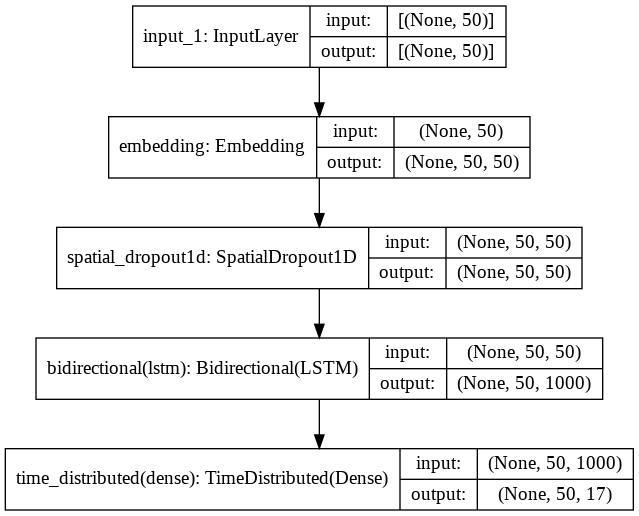

In [12]:
plot_model(model, show_shapes = True)


In [13]:
model.fit(x_train, np.array(y_train), batch_size = 64, verbose = 1, epochs = 10, validation_split = 0.2)

Epoch 1/10
540/540 [==============================] - 188s 337ms/step - loss: 0.2261 - accuracy: 0.9466 - val_loss: 0.1031 - val_accuracy: 0.9704
Epoch 2/10
540/540 [==============================] - 181s 335ms/step - loss: 0.0709 - accuracy: 0.9795 - val_loss: 0.0565 - val_accuracy: 0.9834
Epoch 3/10
540/540 [==============================] - 186s 344ms/step - loss: 0.0452 - accuracy: 0.9866 - val_loss: 0.0506 - val_accuracy: 0.9849
Epoch 4/10
540/540 [==============================] - 186s 345ms/step - loss: 0.0369 - accuracy: 0.9888 - val_loss: 0.0490 - val_accuracy: 0.9854
Epoch 5/10
540/540 [==============================] - 187s 346ms/step - loss: 0.0321 - accuracy: 0.9899 - val_loss: 0.0495 - val_accuracy: 0.9854
Epoch 6/10
540/540 [==============================] - 184s 342ms/step - loss: 0.0288 - accuracy: 0.9908 - val_loss: 0.0488 - val_accuracy: 0.9858
Epoch 7/10
540/540 [==============================] - 182s 337ms/step - loss: 0.0260 - accuracy: 0.9916 - val_loss: 0.0509 -

In [14]:
model.evaluate(x_test, np.array(y_test))


150/150 [==============================] - 4s 30ms/step - loss: 0.0555 - accuracy: 0.9851


[0.05551774054765701, 0.9851084351539612]

In [45]:
rand_sent = np.random.randint(0, x_test.shape[0]) # get a random sentense
print(rand_sent)
p = model.predict(np.array([x_test[rand_sent]]))
p = np.argmax(p, axis = -1)

y_true = np.argmax(np.array(y_test), axis = -1)[rand_sent] # get actual tags for random sentense

print("{:20}{:20}\t{}\n".format("Word", "True", "Pred"))
print("-" * 55)

for (w, t, pred) in zip(x_test[rand_sent], y_true, p[0]):
    print("{:20}{:20}\t{}".format(words[w - 1], tags[t], tags[pred]))

4613
Word                True                	Pred

-------------------------------------------------------
The                 O                   	O
81-year-old         O                   	O
Mr.                 B-per               	B-per
Carter              I-per               	I-per
,                   O                   	O
the                 O                   	O
39th                B-tim               	O
U.S.                B-geo               	B-geo
president           O                   	O
,                   O                   	O
served              O                   	O
from                B-tim               	O
1977                I-tim               	B-tim
to                  I-tim               	I-tim
1981                I-tim               	I-tim
.                   O                   	O
Issa-dominated      O                   	O
Issa-dominated      O                   	O
Issa-dominated      O                   	O
Issa-dominated      O                   	O
Issa-dom

In [94]:
def create_test_input_from_text(text):
    word_list = text.split(" ")
    x_new = []
    for word in word_list:
        x_new.append(word_idx[word])
            
    p = model.predict(np.array(x_new))
    p = np.argmax(p, axis = -1)
    print("{:20}\t{}\n".format("Word", "Prediction"))
    print("-" * 35)

    for (w, pred) in zip(range(len(x_new)), p[0]):
        print("{:20}\t{}".format(word_list[w], tags[pred]))

In [96]:
test_inputs = "the weather in London is very"
create_test_input_from_text(test_inputs)

Word                	Prediction

-----------------------------------
the                 	O


In [73]:
model.save('NER.h5')